In [1]:
from prelude import *
import pandas as pd

In [2]:
conf = SparkConf().setAppName("question4").setMaster("local[*]")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
lines = sc.textFile('../data/French/')
lines = lines.map(lambda line: json.loads(line))

In [7]:
# see the 20 most fequent hashtags 

def get_all_hashtags(s):
    hashtags = s['entities']['hashtags']
    res = []
    for hashtag in hashtags:
        res.append((hashtag['text'], 1))
    return res


lines.flatMap(get_all_hashtags).reduceByKey(lambda a, b: a + b).sortBy(lambda x: x[1], ascending = False).take(20)

[('Macron', 776),
 ('Mila', 691),
 ('Concours', 671),
 ('coronavirus', 610),
 ('LREM', 522),
 ('Paris', 469),
 ('GiletsJaunes', 464),
 ('iHeartAwards', 449),
 ('AsimForTheWin', 404),
 ('ASSEOM', 384),
 ('CONCOURS', 366),
 ('retraites', 352),
 ('Municipales2020', 347),
 ('Brexit', 330),
 ('FCGBOM', 303),
 ('AsliFans', 285),
 ('BB13OnVoot', 284),
 ('RT', 273),
 ('PSGMHSC', 270),
 ('SuperBowl', 267)]

In [36]:
'''
alpha: float, confidence level
target_hashtag: string, the hashtag to perform anomaly detection on 
target_eta: float, threshold for anomaly detection
time_interval_x : int, time interval for a single data point to count hashtags
'''

alpha = 0.99
target_hashtag = 'SuperBowl'
target_eta = 1
time_interval_day = 0
time_interval_hour = 2
time_interval_minute = 0
time_interval_second = 0

date_time_begin_str = 'Fri Jan 31 23:00:00 +0000 2020'
date_time_end_str = 'Fri Feb 07 23:30:00 +0000 2020'
date_time_pattern = '%a %b %d %H:%M:%S %z %Y'
df_date_time_pattern = '%Y-%m-%d %H:%M:%S'

date_time_begin_obj = datetime.datetime.strptime(
    date_time_begin_str, date_time_pattern)
date_time_end_obj = datetime.datetime.strptime(
    date_time_end_str, date_time_pattern)

delta_time = datetime.timedelta(
     seconds=time_interval_second,
     minutes=time_interval_minute,
     hours=time_interval_hour,
     days=time_interval_day,
     )

In [9]:
# see content of one row
lines.take(1)

[{'created_at': 'Fri Jan 31 22:59:55 +0000 2020',
  'id': 1223380418189299714,
  'id_str': '1223380418189299714',
  'text': "@Yazidinhok ptdrrrrrrrrr je sais que c'est du cinema fast-food mais bon même pas un sur les 150 000 sortis, c'est abusé",
  'display_text_range': [12, 119],
  'source': '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>',
  'truncated': False,
  'in_reply_to_status_id': 1223379548525531136,
  'in_reply_to_status_id_str': '1223379548525531136',
  'in_reply_to_user_id': 3435541767,
  'in_reply_to_user_id_str': '3435541767',
  'in_reply_to_screen_name': 'Yazidinhok',
  'user': {'id': 1039569053428469760,
   'id_str': '1039569053428469760',
   'name': 'Walid.',
   'screen_name': 'walid_srh',
   'location': 'Paris, France',
   'url': 'https://twitter.com/warriors/status/741477884888391681?s=21',
   'description': '| W.Y | ceux qui manquent sont déjà partis | T.C.O',
   'translator_type': 'none',
   'protected': False,
   'verified': False,
   'fo

In [10]:
def get_time_period(s, time_bucket_size, time_start_at):
    '''
    Assign the created time period to a tweet. The time periods start at time_start_at, with size of time_bucket_size
    input:
        s: row in RDD
        time_bucket_size: datetiem.timedelta
        time_start_at: datetime.datetime
    
    return:
        date_time_time_period_str: string, the time period the tweet created at
        (date_time_time_period_str, 1)
    '''
    curr_datetime = datetime.datetime.strptime(
        s['created_at'], date_time_pattern)
    date_time_time_period = ((curr_datetime - time_start_at)//time_bucket_size) * time_bucket_size + time_start_at
    date_time_time_period_str = date_time_time_period.strftime('%Y-%m-%d %H:%M:%S')
    return (date_time_time_period_str, 1)
    
    
def filter_hashtag(s, target_hashtag):
    '''
    Filter the tweet who contains target_hashtag
    '''
    hashtags = list(map(lambda h: h['text'], s['entities']['hashtags']))
    return target_hashtag in hashtags

In [11]:
# filter the tweet with target hashtag
tweet_with_hashtag = lines.filter(lambda s: filter_hashtag(s, target_hashtag))

In [12]:
# get the count of tweet with target hashtag within a time inteval
hashtag_trend = tweet_with_hashtag.map(lambda s: get_time_period(s, delta_time, date_time_begin_obj)).reduceByKey(lambda a, b: a + b)

In [13]:
# convert the result into pandas(the size is already small enough)
hashtag_trend_df = spark.createDataFrame(hashtag_trend,schema=['t', 'hashtag_count']).toPandas()

In [22]:
# convert the format of t
hashtag_trend_df['t'] = pd.to_datetime(hashtag_trend_df['t']).dt.strftime(df_date_time_pattern)
hashtag_trend_df = hashtag_trend_df.set_index('t')

In [25]:
from pandas.tseries.offsets import DateOffset

# Create dataframe with full time intervals index 
#(at some time intervals, the tweet count is 0, so no row in hashtag_trend_df to represent this time interval) 
time_index = pd.date_range(start=date_time_begin_obj, end=date_time_end_obj, freq = delta_time, name='t').strftime(df_date_time_pattern)
full_time_index_df = pd.DataFrame(index = time_index)

In [26]:
# Fill in the hashtag_trend_df with full time intervals index 
hashtag_trend_df = full_time_index_df.join(hashtag_trend_df).fillna(0).reset_index()

In [27]:
hashtag_trend_df

,t,hashtag_count
0,2020-01-31 23:00:00,1.0
1,2020-02-01 01:00:00,0.0
2,2020-02-01 03:00:00,0.0
3,2020-02-01 05:00:00,0.0
4,2020-02-01 07:00:00,0.0
...,...,...
80,2020-02-07 15:00:00,0.0
81,2020-02-07 17:00:00,0.0
82,2020-02-07 19:00:00,0.0
83,2020-02-07 21:00:00,0.0


In [29]:
import scipy.stats.distributions as dists

# Calculate eta for each data point

def get_eta(row):
    
    # use simple poisson model, mean = count of the previous point
    # inspired by the code https://github.com/twitterdev/Gnip-Trend-Detection/blob/master/gnip_trend_detection/models.py
    
    index = row.name
    if index == 0:
        return 0
    else:
        last_count = hashtag_trend_df.loc[index-1].hashtag_count
        
    current_count = row.hashtag_count

    if last_count == 0 or current_count == 0:
        return 0

    Delta_r = abs(current_count - last_count) 
    sensitivity = float(Delta_r)/last_count 
    delta_r = dists.poisson.interval(alpha,last_count)[1] - dists.poisson.interval(alpha,last_count)[0]
    relative_confidence_interval = delta_r/last_count
    return sensitivity/relative_confidence_interval


hashtag_trend_df['eta'] = 0.
hashtag_trend_df['eta'] = hashtag_trend_df.apply(get_eta, axis=1)

In [30]:
hashtag_trend_df = hashtag_trend_df.set_index('t')
hashtag_trend_df

,hashtag_count,eta
t,,
2020-01-31 23:00:00,1.0,0.0
2020-02-01 01:00:00,0.0,0.0
2020-02-01 03:00:00,0.0,0.0
2020-02-01 05:00:00,0.0,0.0
2020-02-01 07:00:00,0.0,0.0
...,...,...
2020-02-07 15:00:00,0.0,0.0
2020-02-07 17:00:00,0.0,0.0
2020-02-07 19:00:00,0.0,0.0


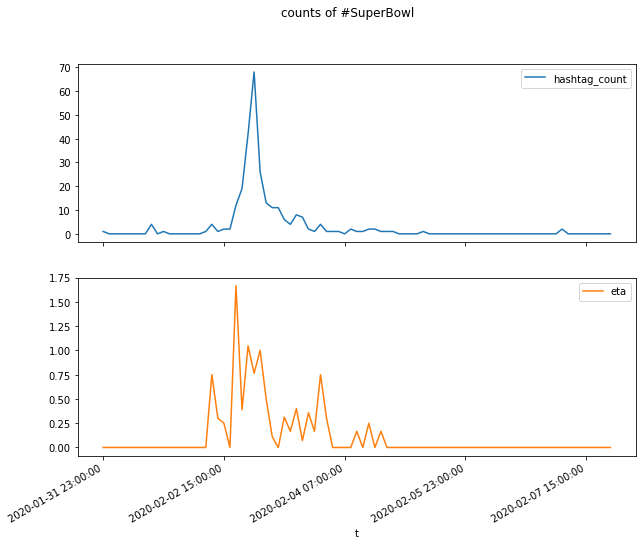

In [34]:
axes = hashtag_trend_df.plot.line(subplots=True, title = 'counts of #' + target_hashtag, figsize = (10,8))

In [39]:
hashtag_trend_df[hashtag_trend_df.eta > target_eta].index

Index(['2020-02-02 19:00:00', '2020-02-02 23:00:00'], dtype='object', name='t')